In [1]:
#-----------------------------------------------------------------------------------------------------------------------------
#
# Loan Eligibility Classification Model
#
# The script creates a model to calculate whether an applicant is eligible for a loan.
# This based on a number of catagorical and continous data fields
# Some of the fields are calculated new independant variables that may give better linear dependancies (potentially) 
# more inisightful (such as Loan to Income)

# The training data set was analysed (in the Loan_History_ML_Eval module) to understand the data
# The script uses shared functions (defined in fn_Aux_Loan_History) to process the data

# The training and test data are loaded

# The user then defines
# .... the subset of parameters to use, 
# .... the columns where null values are filled (catagorical - most poular, numeical mean)
# .... the type of model either Logistic Regression or Linear Support Vector
# .... the cost function to evalaute the performance of the model (of two in library set)

# The model is parameterised based on a set of training data
# The training is done by a series of runs (bootstrapping)
# ... splitting the data into a training and verification set
# ... for a number of variations of regulaisation parameter C
# ... a score is given based on the fraction of values defined as accepted which are true and false (TP and FN)
# ... as this will determine the cost (weighted by the user) of a false acceptance and the benefit of a true acceptance
# ... the training identification output gives the results for every model run

# The training output is analysed (graphically) to asses the regulaisation parameter C that gives the best model (cost)

# The model is created using by running all the training data with the latest tuning data
# The tuning coefficents are presented to give an insight into how the parameter selection can be adapted

# The model is reran against the test data provided to indicate which new applicants should be recomended for approval
# The results are saved (if option is selected) as a pickle for storage and further analysis

# The interntion is that the script is ran iteratively with the parameter combinations selected by the user
# This could be modified (in future) to allow combinations of parameters to be ran in a batch

In [2]:
#-----------------------------------------------------------------------------------------------------------------------------
# Rev     By                Description
# 1.3    Richard Brooks     Fixed Seed
# 1.2    Richard Brooks     Adpated so can take Linear SVM and Logistic Regression Models
# 1.1    Richard Brooks     Tidy Up
# 1.0    Richard Brooks     Initial Release

sScript = 'Loan History Modelling'
sVersion = 'v1.23'
sAuthor = 'Richard W Brooks'

print ('Running : ' + sScript + ' : ' + sVersion)

Running : Loan History Modelling : v1.23


In [3]:
# Importing python libraries and running file with bespoke functions

import numpy as np
import pandas as pd
import pickle
import re
import datetime as dt
import random as rd
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

# import warnings filter
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Fix Seed
rd.seed(1)

In [4]:
# -------------------------------------------------------------------------------------------------------------------------
# 0. Loading and defining functions
# -------------------------------------------------------------------------------------------------------------------------

In [5]:
run fn_Aux_Loan_History.ipynb

Running : Loan History Auxillary Functions : v1.2


In [6]:
# Options for the classification model
# Can take Logistic Regression or Linear SVM (default parameter set in function)

def fn_clf_Logistic (x_t, y_t, *args):
    CVal = args[0]
    clf = LogisticRegression(C = CVal, max_iter=1000,solver='lbfgs').fit(x_t, y_t)
    return clf

def fn_clf_Linear_SVM (x_t, y_t, *args):
    CVal = args[0]
    clf = SVC(kernel='linear', C = CVal).fit(x_t, y_t)
    return clf

In [7]:
# Functions options for the cost function are defined as dictionaries so that the corresponding headings can be extracted
# These input actual and predicted values, (and if required parameters)
# They output a score - conistent with teh header

# Weighted Average Cost
# Gives a weighted average score based on a set of weights
# Inputs : weighting given to ['TN', 'FP', 'FN', 'TP'] 
# Outputs : prediction ['TN', 'FP', 'FN', 'TP'], 'T' (number predicted as true), 'SCORE' (weighted score, based on input)
# ... caluates the confusion metric coverts to fraction, then True and Weighted Score based on array input

ls_Weight_Model_Score_Fields = ['TN', 'FP', 'FN', 'TP', 'T', 'SCORE']

def fn_ls_Weight_Model_Score(y_act, y_pred, *args):
    
        ls_weight = args[0]
        valid_confusion = confusion_matrix(y_act, y_pred, labels=[0,1])
        ls_vc = valid_confusion.flatten().tolist()
        ls_vc = [i/sum(ls_vc) for i in  ls_vc]
        
        t = sum([x * y for x, y in zip(ls_vc, [0,0,1,1])])
        ws = sum([x * y for x, y in zip(ls_vc,ls_weight)])
        
        ls_sc = ls_vc + [t, ws]
        
        return ls_sc
    
dict_Weight_Model_Score = {'ls_Fields':ls_Weight_Model_Score_Fields, 'fn' : fn_ls_Weight_Model_Score}

In [8]:
# Area Under Curve
# Gives the area under the False Possotive / True Possotive Curve - the closer to 1 the better the model
# Inputs : no additional
# Outputs : prediction ['Precsion : TP/(TP+FP)', 'Recall : TP/(TP+FN)', Area Under Curve)

ls_AUC_Score_Fields = ['PREC', 'RECALL', 'SCORE']

def fn_ls_AUC_Score(y_act, y_pred, *args):

        p = precision_score(y_act, y_pred)
        r = recall_score(y_act, y_pred)
        auc = roc_auc_score(y_act, y_pred)   
        ls_sc = [p, r, auc]
        
        return ls_sc
    
dict_AUC_Model_Score = {'ls_Fields':ls_AUC_Score_Fields, 'fn' : fn_ls_AUC_Score}

In [9]:
# -------------------------------------------------------------------------------------------------------------------------
# 1. Loading the raw data and pre-processing
# -------------------------------------------------------------------------------------------------------------------------

In [10]:
# Load the raw data sets provided
df_test_raw = pd.read_csv('test_Y3wMUE5_7gLdaTN.csv')
df_train_raw = pd.read_csv('train_u6lujuX_CVtuZ9i.csv')

df_test = df_test_raw.copy()
df_train = df_train_raw.copy()

In [11]:
# Pre processing the data

# Translate the Output in the training set to a 0/1 value for training
df_train['Loan_Status'] = (df_train['Loan_Status']=='Y').astype(int)

# Change the format of fields and create calculated parameters for inputs (defined in auxillary functions)
df_PreProcess_Data(df_train)
df_PreProcess_Data(df_test)

In [12]:
df_train.head(n=5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,c_JointIncome,c_Loan_per_Month,c_Loan_per_AppIncome,c_Loan_per_JointIncome
0,1002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,Yes,Urban,1,5849.0,NaN,NaN,NaN
1,1003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,Yes,Rural,0,6091.0,0.355556,0.027929,0.021015
2,1005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,Yes,Urban,1,3000.0,0.183333,0.022000,0.022000
3,1006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,Yes,Urban,1,4941.0,0.333333,0.046458,0.024287
4,1008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,Yes,Urban,1,6000.0,0.391667,0.023500,0.023500


In [13]:
df_test.head(n=5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,c_JointIncome,c_Loan_per_Month,c_Loan_per_AppIncome,c_Loan_per_JointIncome
0,1015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,Yes,Urban,5720,0.305556,0.019231,0.019231
1,1022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,Yes,Urban,4576,0.350000,0.040962,0.027535
2,1031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,Yes,Urban,6800,0.577778,0.041600,0.030588
3,1035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,No,Urban,4886,0.277778,0.042735,0.020467
4,1051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,Yes,Urban,3276,0.216667,0.023810,0.023810


In [14]:
# Calculate the fraction of fields in training and test data that have NaN values
# Show this to inform the user for filling NA values

# Columns with null values
iRow = df_test.shape[0]
df_test_NA = df_test.isna().sum().sort_values()
df_test_NA = df_test_NA[df_test_NA>0]/iRow

# Columns with null values
iRow = df_train.shape[0]
df_train_NA = df_train.isna().sum().sort_values()
df_train_NA = df_train_NA[df_train_NA>0]/iRow

df_train_test_NA = df_train_NA.to_frame().rename(columns = {0:'train_NA'}).join(df_test_NA.to_frame().rename(columns = {0:'test_NA'}))

df_train_test_NA

,train_NA,test_NA
Married,0.004886,NaN
Gender,0.021173,0.029973
Loan_Amount_Term,0.022801,0.016349
Dependents,0.024430,0.027248
LoanAmount,0.035831,0.013624
c_Loan_per_AppIncome,0.035831,0.019074
c_Loan_per_JointIncome,0.035831,0.013624
Self_Employed,0.052117,0.062670
c_Loan_per_Month,0.058632,0.029973


In [15]:
# The paramters with defined types (found by analysis / inspection in the model evaluation)

# The output to be predicted
ls_Col_Out = ['Loan_Status']

# The catagorical variables in the data set
ls_Col_Cat = ['Dependents','Education', 'Property_Area','Gender','Married','Self_Employed','Credit_History']

In [16]:
# Show the user what columns are in the data set - have these at hand to copy/psate for selection
df_train.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status',
       'c_JointIncome', 'c_Loan_per_Month', 'c_Loan_per_AppIncome',
       'c_Loan_per_JointIncome'],
      dtype='object')

In [17]:
# -------------------------------------------------------------------------------------------------------------------------
# 2. User Inputs
# -------------------------------------------------------------------------------------------------------------------------

In [18]:
# The user defines how the data is to be modelled
# ... these inputs can be adjusted to refine the model based on results

# The user then defines
# .... the subset of parameters to use, 

# The independant cause varaibles to be chosen for consideration in the model
ls_Col_Indie = ['Self_Employed','Property_Area','Credit_History','LoanAmount','c_Loan_per_AppIncome']

# The varaibles where an assumption is made to fill NA values  (catagorical - most poular, numeical mean)
# ... if the varaiable is not in this list then the row containing NA value is deleted
ls_Col_Fill_NA = ['Married', 'Gender', 'Loan_Amount_Term', 'Self_Employed', 'Credit_History']

# ... the function to use (with default parmeters execept regularisation)
# Comment out the ones not used

# OPTION A: Logistic Regression 
fn_clf_Model = fn_clf_Logistic

# OPTION B: Linear Support Vector Machine
#fn_clf_Model = fn_clf_Linear_SVM

# .... the cost function to evalaute the performance of the model (of two in library set)
# Comment out the ones not used

# OPTION A: Weighted Average : True Possotive gives income, False Possotive gives loss
# Change here to select the cost function and output columns from list
dict_Model_Cost = dict_Weight_Model_Score
arg_Model_Cost = [0, -1, 0, 1] # Cost Weight -  ['TN', 'FP', 'FN', 'TP']

# OPTION B: Area Under Curve : Fraction of distingusihing good / bad loan
#dict_Model_Cost = dict_AUC_Model_Score
#arg_Model_Cost = np.NaN

# .... the setting for parameter tuning

# Vales of Regularisation Coeffient 'C', large value more complex but may be over-fitting 
ls_Reg_COpts = [0.1, 0.5, 1, 2.5, 5, 7.5, 10, 25, 50] 

 # Fraction of data used for training and validation
d_Valid_Data_Perc = 0.2

# Number of runs per evaluation (of co-efficent)
i_BootstrapRuns = 200

# ... Whether want to save the main results (as a Pickle) and the associated filename
bSaveOutputPickle = True
sOutputFileBase = 'Loan_History_LR_Model'
sRunDec = 'Linear Logistic Regression Joint and Combined Income'

In [19]:
# -------------------------------------------------------------------------------------------------------------------------
# 3. Model Training (Bootstrap)
# -------------------------------------------------------------------------------------------------------------------------

In [20]:
# Process the Training Data for Model Evaluation

# Select the columns in the training data to use
# Process the NA values - if they are in the list select ... delete the rows for values with remaining NA values
# Normalise the data - so all is between 0 and 1, catagorical data regers to the fields with 1 if matches, 0 of not

ls_Col = list(set(ls_Col_Out + ls_Col_Indie))
df_train = df_FillNA_Data(df_train, ls_Col, ls_Col_Fill_NA, ls_Col_Cat)

df_train_p = df_Prep_Data(df_train,ls_Col_Cat)

In [21]:
# Run a set of model evaluations
# Conduct a set of runs where split the training data into two sets (identification and validation)
# ....For the options of regularisation parameters (C):
# ... .... Fit the model based on the the training set, evlaute based on the validation set using the score

ls_Score = []
iSet = 1 # the script is just evaluating one set of parameter selection, this may be more if the script is adapted in future

for iRun in range(i_BootstrapRuns):
    
    # Splitting the data
    df_ident_p, df_valid_p = train_test_split(df_train_p, test_size=d_Valid_Data_Perc)

    #Select the output data
    y_train = df_ident_p[ls_Col_Out].copy().values.ravel()
    y_valid = df_valid_p[ls_Col_Out].copy().values.ravel()

    #The remaining columns are inputs
    ls_Col_x_p = list(set(df_train_p.columns) - set(ls_Col_Out))
    x_train = df_ident_p[ls_Col_x_p]
    x_valid = df_valid_p[ls_Col_x_p]
    
    
    # For each regularisation parameter
    for CVal in ls_Reg_COpts:
        
        # Run the model on the training set
        clf = fn_clf_Model(x_train, y_train, CVal)
        
        # Evaluate the model on the test set and give it a score based on the function
        y_valid_pred = clf.predict(x_valid)
        ls_sc = dict_Model_Cost.get('fn')(y_valid, y_valid_pred, arg_Model_Cost)

        # Keep appending the results for each run, using parameters to define the run and the score
        ls = [iSet, iRun, CVal] + ls_sc
        ls_Score.append(ls)

In [22]:
# Repeat the scoring based on a dummy classfier as a comparison
# ... In the absence of any data you could just assign at random based on the fraction previously accepted
# ... This therefore just compares two splits of the outputs based on the size of the validation data

ls_Dummy_Score = []

y_train = df_train['Loan_Status'].tolist()
iSample = int(len(y_train )*d_Valid_Data_Perc)
ls_Dummy_Score = []

# Take two data splits and run teh model function
# In the list define the parameter set and C value to 0
for iRun in range(i_BootstrapRuns):
    y_valid = rd.sample(y_train,iSample)
    y_dummy_pred = rd.sample(y_train,iSample)
    ls_sc = dict_Model_Cost.get('fn')(y_valid, y_dummy_pred, arg_Model_Cost)
    
    ls = [0, iRun, 0] + ls_sc
    ls_Dummy_Score.append(ls)    

In [23]:
# Convert the run score to data list to interogate
# This pulls the varaible list associated with the cost function (that is why store in dictionary)
df_Sc = pd.DataFrame(ls_Score + ls_Dummy_Score, columns=['Pm Set', 'Run', 'C'] + dict_Model_Cost.get('ls_Fields'))

In [24]:
# -------------------------------------------------------------------------------------------------------------------------
# 4. Model Training Evaluation
# -------------------------------------------------------------------------------------------------------------------------

<IPython.core.display.Javascript object>


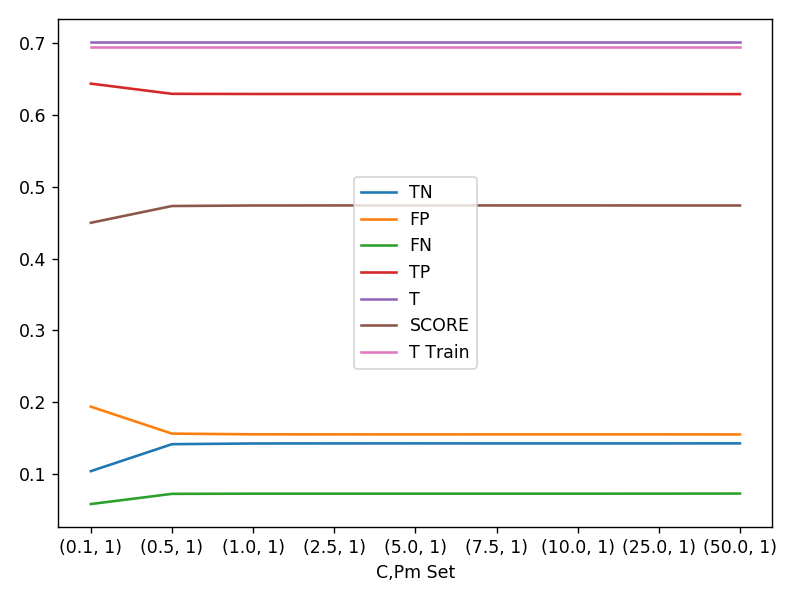

In [25]:
# Look at the mean results of the runs to assess average sucess
# Compare on the graph the fraction of true values in the training data (as a check)

df_SC_mean = df_Sc[df_Sc['C']>0].groupby(['C','Pm Set']).mean()
df_SC_mean['T Train'] = (df_train['Loan_Status'].value_counts()/len(df_train))[1]

df_SC_mean.plot(kind='line', y = dict_Model_Cost.get('ls_Fields') + ['T Train'])
plt.tight_layout()

<IPython.core.display.Javascript object>


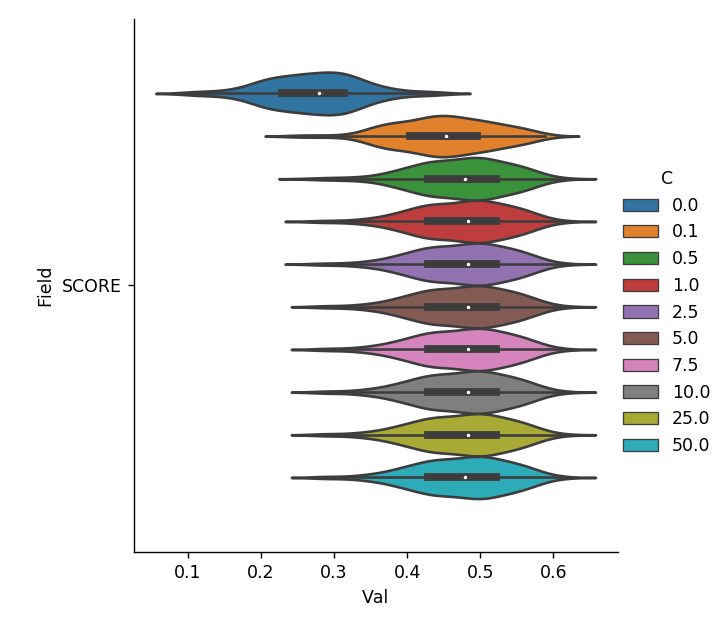

In [26]:
# Look at the distribution in the results for the individal runs (as an indication of outliers)
# Include the dummy classification C = 0 to compare against
# This could be copied and pasted if wnat to look at more score varaibles

df_Sc_L = pd.melt(df_Sc ,id_vars=['C','Pm Set','Run'], var_name='Field', value_name='Val')
sns.catplot(x = "Val", y = "Field", hue = 'C', kind = "violin", data = df_Sc_L[df_Sc_L['Field'] == 'SCORE'])

In [27]:
# Select the best model parameter
# The score is the maximum value at 95% lower confidence limit

# This could / should be done by eyeballing the results to where the score falls off
# to better inform the choice of parameter and how it comapred with other runs

# The higher value of C the more complex but may be over-fitting, would select C by eyeballing here 

ls_Score_CI = []
d_CI = 0.95

for CVal in df_Sc['C'].unique():
    ls = df_Sc['SCORE'][df_Sc['C'] == CVal]
    d_Sc_CI = st.t.interval(alpha=d_CI, df=len(ls)-1, loc=np.mean(ls), scale=st.sem(ls))
    ls_Score_CI.append([CVal, d_Sc_CI[0], d_Sc_CI[1] - d_Sc_CI[0],] )
    
df_Score_CI = pd.DataFrame(ls_Score_CI, columns=['C','SCORE','BAND' ])
df_Score_CI = df_Score_CI[df_Score_CI['C']>0]
df_Score_CI.set_index('C', inplace = True)

CSel = df_Score_CI.idxmax(axis=0)[0]
print ('Regularisation Parameter Selected C : ' + str(CSel))

df_Score_CI

Regularisation Parameter Selected C : 5.0


,SCORE,BAND
C,,
0.1,0.440736,0.018612
0.5,0.464483,0.017840
1.0,0.465232,0.017772
2.5,0.465315,0.017772
5.0,0.465381,0.017726
7.5,0.465333,0.017738
10.0,0.465339,0.017726
25.0,0.465288,0.017743
50.0,0.465272,0.017691


In [28]:
# -------------------------------------------------------------------------------------------------------------------------
# 5. Run the model on the training and test data
# -------------------------------------------------------------------------------------------------------------------------

In [29]:
# Run the selected model on the full training data set (so teh model is tuned against the maximum available data)

y_train = df_train_p[ls_Col_Out].copy().values.ravel()

ls_Col_x_p = list(set(df_train_p.columns) - set(ls_Col_Out))
x_train = df_train_p[ls_Col_x_p]

clf_sel = fn_clf_Model(x_train, y_train, CSel)

In [30]:
# View the results of the model on the Training data
y_train_pred = clf_sel.predict(df_train_p[ls_Col_x_p])
ls_sc_pred = dict_Model_Cost.get('fn')(df_train_p[ls_Col_Out], y_train_pred, arg_Model_Cost)

df_train_sc = pd.DataFrame({'Field':dict_Model_Cost.get('ls_Fields'), 'Val': ls_sc_pred})
df_train_sc.T

,0,1,2,3,4,5
Field,TN,FP,FN,TP,T,SCORE
Val,0.153716,0.152027,0.0743243,0.619932,0.694257,0.467905


In [31]:
# Extract the model coeffients
df_Model_Coeff = pd.DataFrame({'Parm' : ls_Col_x_p, 'Coff' : clf_sel.coef_.tolist()[0]}).sort_values('Parm')
df_Model_Coeff.set_index('Parm', inplace = True)

In [32]:
# -------------------------------------------------------------------------------------------------------------------------
# 6. Generate the prediction for the test data
# -------------------------------------------------------------------------------------------------------------------------

In [33]:
# Process the test data for running the model

# Handle NaN and normalise values as per the training data
df_test = df_FillNA_Data(df_test, ls_Col_Indie, ls_Col_Fill_NA, ls_Col_Cat)
df_test_p = df_Prep_Data(df_test,ls_Col_Cat)

# Check and handle any columns that are missing - (as there may be some catagory differences)
ls_Add_Col = list(set(df_test_p.columns) - set(df_Model_Coeff.index).intersection(ls_Col_x_p))

if len(ls_Add_Col) == 0:
    print ('INFO : All columns in test set exist in training set')
else:
    print ('WARNING : Adding Additional Columns as NAN' + ', '.join(map(str, ls_Add_Col)))
    for sCol in ls_Add_Col:
        df_test_p[sCol] = np.nan

INFO : All columns in test set exist in training set


In [34]:
# Run the model
y_train_test = clf_sel.predict(df_test_p)   

# Add the output to the test data
df_test_results = df_test.copy()
df_test_results[ls_Col_Out[0]] = y_train_test

df_test_results_p = df_test_p.copy()
df_test_results_p[ls_Col_Out[0]] = y_train_test

In [35]:
# -------------------------------------------------------------------------------------------------------------------------
# 7. Analyse the parameters - prediction and correlations to inform next iteration
# -------------------------------------------------------------------------------------------------------------------------

In [36]:
# Provide an indication of the loans that would be approved by applying the model

# ... looks the training data actuals and model predicton
# ... how this compares to the test data - whether this can be explained by higher values of fields and coefficients

print('Training Data : {0:.3f}'.format(y_train.sum()/len(y_train)))
print('Training Data Prediction : {0:.3f}'.format(y_train_pred.sum()/len(y_train_pred)))
print('Test Data Prediction : {0:.3f}'.format(y_train_test.sum()/len(y_train_test)))

Training Data : 0.694
Training Data Prediction : 0.772
Test Data Prediction : 0.103


<IPython.core.display.Javascript object>


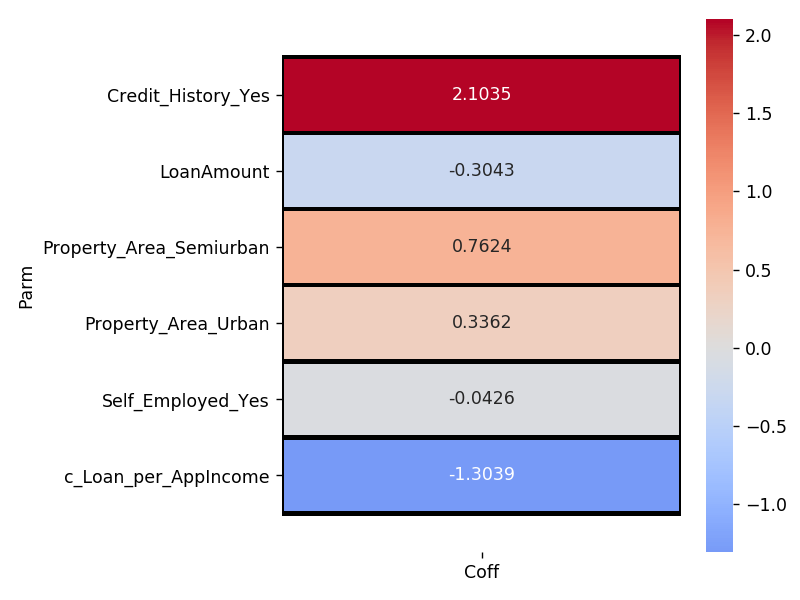

In [37]:
# Extract the parameters and display these - to give an indication of how important the parmaeters are
plt.figure()
sns.heatmap(df_Model_Coeff,cmap='coolwarm',annot=True, fmt='.4f', center= 0, linewidths=2, linecolor='black')
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.tight_layout()

<IPython.core.display.Javascript object>


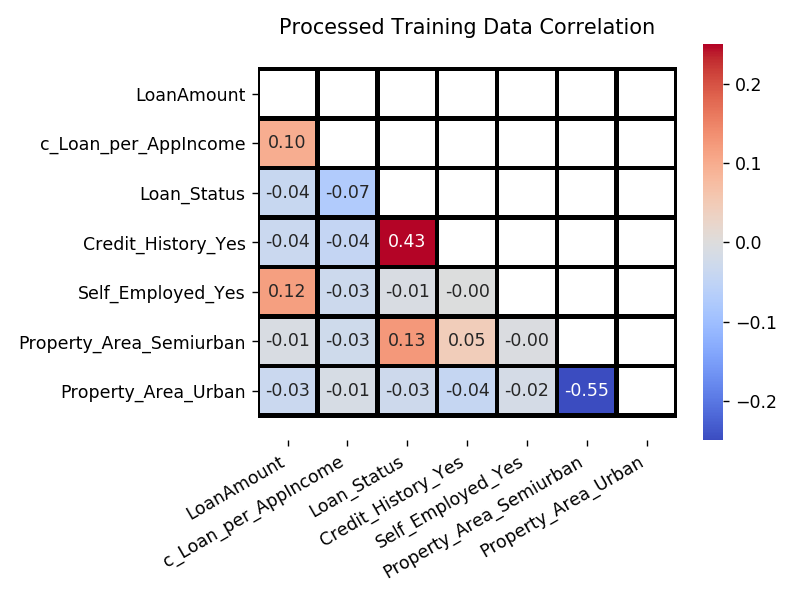

In [38]:
# Produce correlation plot to understand inter dependancies
# Note this could be done before modelling on a large data set where fitting would be tome consuming
fn_plt_correlation_heat_map(df_train_p,'Processed Training Data Correlation')

<IPython.core.display.Javascript object>


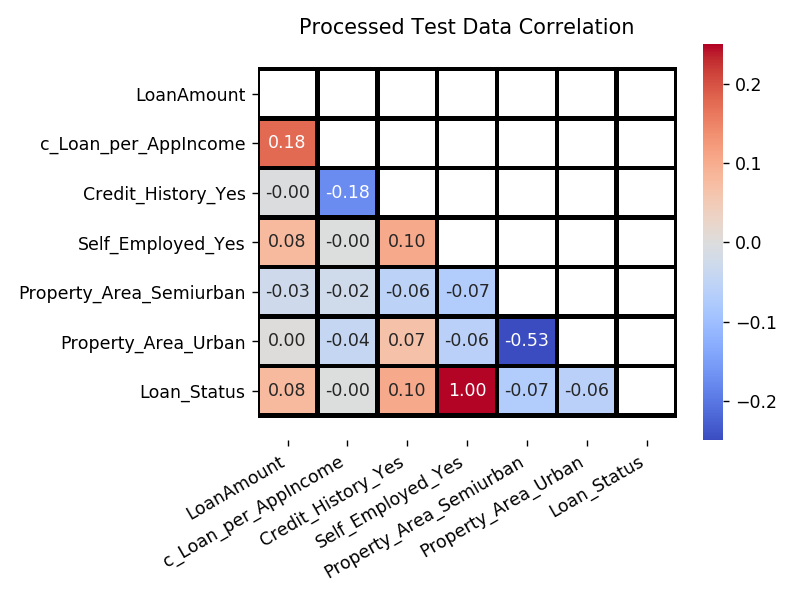

In [39]:
fn_plt_correlation_heat_map(df_test_results_p,'Processed Test Data Correlation')

<IPython.core.display.Javascript object>


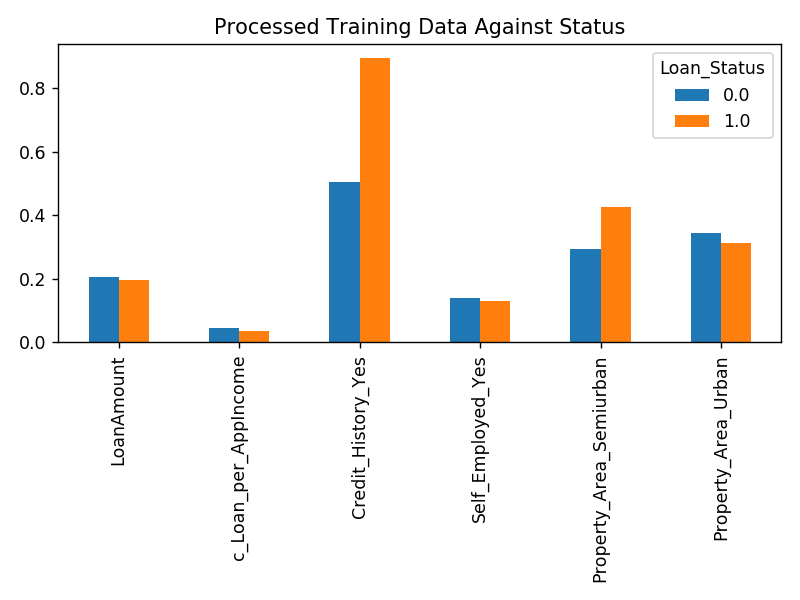

In [40]:
# Produce a bar plot showing the average value of parameter in accepted and unaccepted cases
# This indiactes any data skew in distribution and difference in outcome
fn_plt_bar_ratio(df_train_p,ls_Col_Out,'Processed Training Data Against Status')

<IPython.core.display.Javascript object>


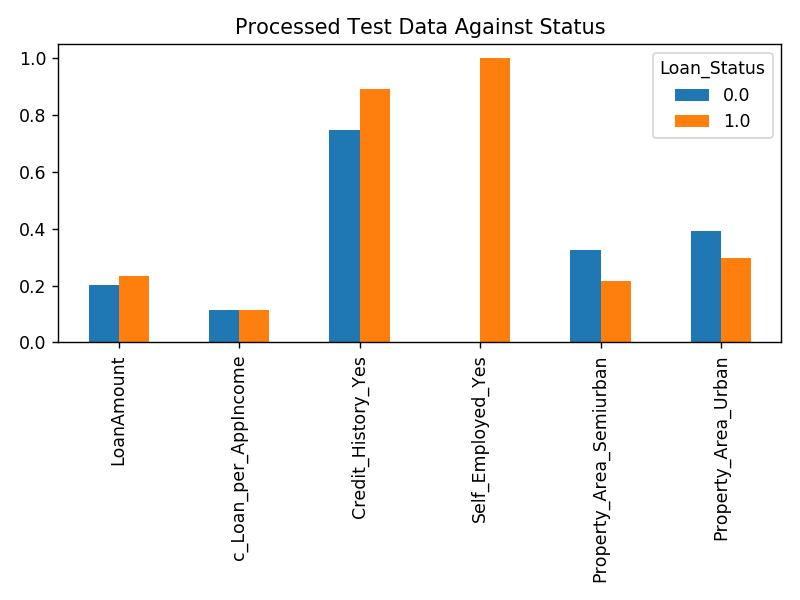

In [41]:
fn_plt_bar_ratio(df_test_results_p,ls_Col_Out,'Processed Test Data Against Status')

In [42]:
# -------------------------------------------------------------------------------------------------------------------------
# 8. Colate and Save Parameters and Output
# -------------------------------------------------------------------------------------------------------------------------

In [43]:
# Create a dictionary with the key parameter values
dict_Output = {'clf_sel':clf_sel, 'df_test_results':df_test_results, 'df_train_p':df_train_p,
              'df_Sc' : df_Sc, 'sVersion' : sVersion, 'sRunDec' : sRunDec,
              'ls_Col_Indie' :  ls_Col_Indie, 'ls_Col_Fill_NA' : ls_Col_Fill_NA ,'ls_Col_Cat': ls_Col_Cat}

# Add timestamp to the file
sOutputFileName = sOutputFileBase + '_' + dt.datetime.now().strftime("%m-%d-%y-%H%M%S") + '.pck'

# Save this as pickle so it can be arhived
if bSaveOutputPickle:
    pickle.dump(dict_Output,open(sOutputFileName,"wb"))

In [44]:
# -------------------------------------------------------------------------------------------------------------------------
# End of Script
# -------------------------------------------------------------------------------------------------------------------------